# PSDS evaluation for DCASE 2020 Task 4


This notebook shows how the Polyphonic Sound Detection Score (PSDS) [[1]](#References) evaluation can be used to extract performance insights for a Sound Event Detection (SED) system. It also uncovers and explains the key features of the novel evaluation framework employing a real system and a real dataset.  
The system used throughout this notebook is the official baseline model of DCASE 2020 Challenge [Task 4](http://dcase.community/challenge2020/task-sound-event-detection-and-separation-in-domestic-environments). 

>The PSDS is a metric for evaluating SED systems. Differently from other widely adopted metrics, PSDS:
>- Introduces a new, flexible and robust definition of event detection that yields an evaluation closer to the end-user perception of sound events
>- Discriminates cross-triggers from generic false positives and supports their custom weighting to cope with imbalanced datasets and to help developers to identify the system weaknesses
>- Evaluates the SED system performance using multiple operating points to truly measure the quality of the sound event modelling without the system calibration bias

The baseline system performance against the validation dataset can be extracted by following the instructions presented [in this GitHub page](https://github.com/turpaultn/dcase20_task4/tree/public_branch/baseline). However, in order to keep the notebook tidy, the data necessary to compute PSDS evaluation has been pre-extracted and cached:
- `./cache/validation_groundtruth.tsv` the official tab-separated-value file. An excerpt:
  ```
  filename	onset	offset	event_label
Y00pbt6aJV8Y_350.000_360.000.wav	0.000	9.971	Vacuum_cleaner
Y00pK0GMmE9s_70.000_80.000.wav	0.000	10.000	Vacuum_cleaner
Y02sD1KJeoGA_50.000_60.000.wav	0.000	10.000	Frying
Y0bjUq9XMMmQ_30.000_40.000.wav	0.000	10.000	Frying
  ```
- `./cache/validation_metadata.tsv` the tab-separated-value file computed when running [TestModel.py](https://github.com/turpaultn/dcase20_task4/tree/public_branch/baseline#sed-only)
   ```
  filename	duration
Y0MV5mb0RJLY_120.000_130.000.wav	10.0
YAagLJkfrFMk_60.000_70.000.wav	10.0
YU7WkuGO-lps_20.000_30.000.wav	10.0
   ```
- `./cache/validation_predictions/*.tsv` the set of baseline event detections created by TestModel.py when the output threshold is varied linearly from 0.01 to 0.99. This file looks like the `validation_groundtruth.tsv` but contains the system detections.

For more info about PSDS, installation and the getting started guide please refer to the [PSDS official GitHub repo](https://github.com/audioanalytic/psds_eval).

Finally, if you are using PSDS in your work, please cite this [paper](#References).

**Table of contents**
- [Your first PSDS evaluation](#Your-first-PSDS-evaluation)
- [System stability and cross-trigger mistakes](#System-stability-and-cross-trigger-mistakes)
- [PSDS vs threshold sweep](#PSDS-vs-threshold-sweep)
- [A flexible and robust evaluation framework](#A-flexible-and-robust-evaluation-framework)
- [References](#References)
---

## Your first PSDS evaluation
Let's start by importing the necessary packages used throughout the entire notebook.

In [1]:
import glob
import os.path as osp
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from psds_eval import PSDSEval, plot_psd_roc, plot_per_class_psd_roc

The cached validation dataset *ground truth* and *metadata* are loaded here. The metadata file contains the duration, expressed in seconds, of each file in the dataset.

In [2]:
groundtruth = pd.read_csv("cache/validation_groundtruth.tsv", sep="\t")
metadata = pd.read_csv("cache/validation_metadata.tsv", sep="\t")

`PSDSEval` can be instantiated easily by passing the two tables previously created.
>Notice that a number of evaluation parameters are set to their default values. Later sections of this notebook will present these parameters in more detail.

In [3]:
psds_eval = PSDSEval(ground_truth=groundtruth, metadata=metadata)

The cached set of detections from the system at different output thershold values `./cache/validation_predictions/{0.010,0.030,...,0.990}.tsv` are now read and passed to `psds_eval`:

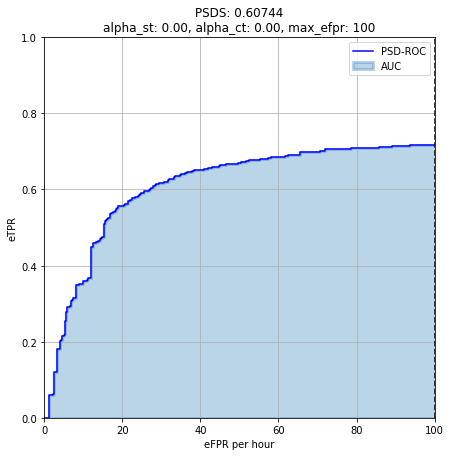

In [4]:
# in case this cell is executed many times, let's clean the PSDSEval
psds_eval.clear_all_operating_points()

for i, tsv in enumerate(glob.glob(osp.join("./cache/validation_predictions/*.tsv"))):
    print(f"Adding Operating Point {i+1:02d}/50", end="\r")
    det = pd.read_csv(tsv, sep="\t")
    psds_eval.add_operating_point(det)
    
# compute the PSDS of the system represented by its operating points
psds = psds_eval.psds(max_efpr=100)
# plot the PSD-ROC and corresponding PSD-Score
plot_psd_roc(psds)

Done! The graph above shows the PSD-ROC of the system and its **PSD-Score is 0.60744** which is the area under the curve computed up to the given `max_efpr` value.  
The x and y axis of a PSD-ROC plot are the *effective False Positive Rate* (eFPR) and the *effective True Positive Ratio* (eTPR) which are defined below (please find more detail in [[1]](#References)):. 

<a id="efpr-etpr-definition"></a>
**effective False Positive Rate**

> eFPR combines false positive (FP) and cross-trigger (CT) rates through the parameter `alpha_ct`: $$\text{eFPR} = \{ x\,|\, x = \text{FPR}_c + \alpha_{\text{CT}} \cdot \text{mean}(\text{CTR}_c) \, , \forall c \in C\}, \quad \text{where}\, C \,\text{is the set of sound classes}$$

**effective True Positive Ratio**

> eTPR is defined using both the mean and the standard deviation of true positive (TP) ratios across classes. The importance of inter-class variability is controlled throught the parameter `alpha_st`: $$\text{eTPR} = \mu_{\text{TPR}_c} - \alpha_{\text{ST}} \cdot \sigma_{\text{TPR}_c}$$

### Intersection-based F-score
`PSDSEval` can also compute class-dependent F-score and macro F-score. The latter is defined as the average of the former.  
This is particularly useful if you want to compute a well-known metric, but based on the novel and robust *intersection logic* (explained in more detail [below](#A-flexible-and-robust-evaluation-framework)) introduced by PSDS evaluation.

In [5]:
det = pd.read_csv("cache/validation_predictions_default-thr.tsv", sep="\t")
macro_f, class_f = psds_eval.compute_macro_f_score(det)
print(f"macro F-score: {macro_f*100:.2f}")
for clsname, f in class_f.items():
    print(f"  {clsname}: {f*100:.2f}")

macro F-score: 59.43
  Alarm_bell_ringing: 78.62
  Blender: 54.10
  Cat: 60.66
  Dishes: 36.07
  Dog: 59.36
  Electric_shaver_toothbrush: 59.76
  Frying: 40.13
  Running_water: 60.98
  Speech: 85.17
  Vacuum_cleaner: 59.49


## System stability and cross-trigger mistakes

This section digs into the information summarised in the PSD-ROC plot seen above by visualising the per-class PSD-ROC curves. Furthermore, the cross-trigger importance parameter `alpha_ct` and the stability parameters `alpha_st` are varied to show how they affect the curves.  
This type of analysis gives a deeper level of insight into how the model behaves when putting more emphasis on cross-trigger mistakes or inter-class variability.

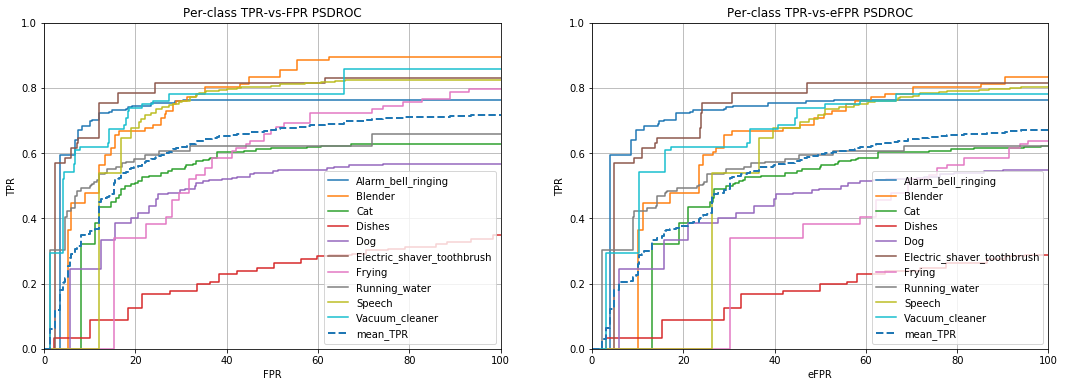

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval.psd_roc_curves(alpha_ct=1.)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

Both figures above refer to the DCASE 2020 baseline system. In particular, the figure on the left shows the set of ROC curves (TPR-vs-FPR) in which those drawn in solid lines are class-dependent ROCs whilst the dashed one is the average TPR across classes. Note that this average curve is the same showed in previous PSD-ROC plot. This is the case since both parameters `alpha_ct` and `alpha_st` are set to zero (cf. [eFPR/eTPR definition](#efpr-etpr-definition)).

**Cross-trigger mistakes**

The figure on the right instead presents a *worse* situation even if the tested system is exactly the same. The figure was indeed generated using `alpha_ct = 1.0` which injects the cross-triggers (CTs) errors into the standard FPs leading to the *effective False Positive Rate* (eFPR). Varying the value of `alpha_ct` has the effect of controlling how important CTs are in the final evaluation. As explained in the paper [[1]](#References), this is crucial when the dataset is unbalanced or when the normally low probability of occurrence of a sound has to be artificially increased in order to perform a significant evaluation (e.g. glass breaking).

**System stability**

Let's now plot the same PSD-ROC curve, but with the flag `en_std=True`. The PSD-ROC curve (`eTPR = mean(TPR_class)`) is unchanged but the `std(TPR_class)` is now visible and it reveals the inter-class variability even without plotting the per-class ROC curves.

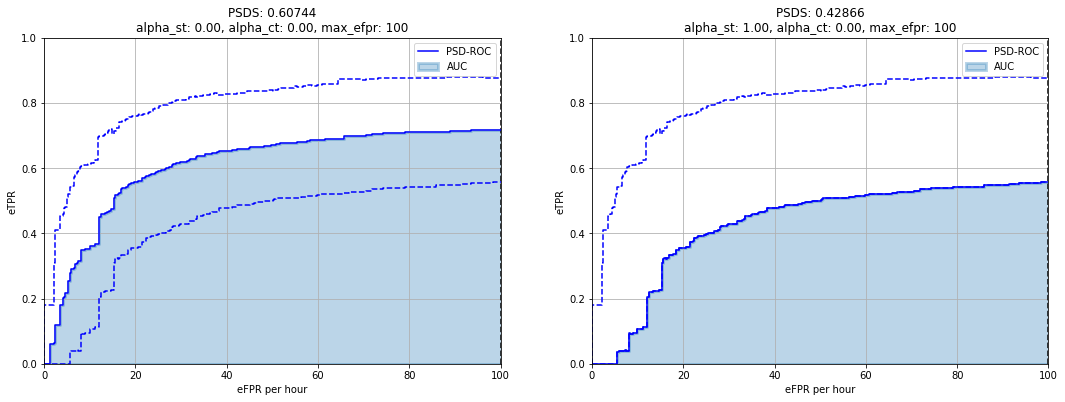

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# this is the same figure seen at the beginning, replot to help the comparison
plot_psd_roc(psds, en_std=True, axes=axes[0])

# re-evaluate system's psds with alpha_st = 1.0
psds = psds_eval.psds(alpha_st=1., max_efpr=100)
plot_psd_roc(psds, en_std=True, axes=axes[1])

The figure on the left is the same PSD-ROC plotted earlier in this notebook (i.e. `alpha_st = 0.`), while the figure on the right shows how the PSD-ROC curve changes when `alpha_st = 1.` The PSD-Score drops from 0.6074 to 0.4287 suggesting that there's a significant difference in performance between the 10 classes. This confirms what it was previously shown by the per-class [PSD-ROC plot](#perclassrocs).

Computing PSD-Score with different `alpha_st` values gives insights about the system stability across classes. A system with a significant inter-class variability will have a lower PSD-Score when `alpha_st` is non-zero.

---

## PSDS vs threshold sweep

PSDS evaluation uses multiple operating points to extract performance which are indepenent from the system tuning. In fact, an operating point is a specific tuning of the system and it is represented by the set of detections a system produces on a dataset when such tuning is applied.  
For the DCASE Task 4 baseline, 50 operating points have been extracted by varying the output threshold value from 0.1 to 0.99 and the system event detections for each threshold are saved in a `tsv` file (see introduction of this notebook for an example).

When using `PSDSEval` to investigate the performance of a SED system, it is important to extract a sufficient number of operating points and to ensure that the set of operating points produces a smooth PSD-ROC curve and there are no large gaps between points. Let's see if the 50 linearly spaced threshold values used can be improved by using a logspaced set:

In [8]:
n_thresholds = 50
lin_thresholds = np.linspace(0.1, 0.99, n_thresholds)
log_thresholds = 1. - np.exp(np.linspace(np.log(1 - 0.99999), np.log(1 - 0.1), n_thresholds))[::-1]

As previously done, let's instantiate the `PSDSEval` object, add the new operating points (cached in `./cache/validation_predictions_logthr`). Notice that a new instance is created `psds_eval_log` so that we can easily produce a comparative plot later:

In [9]:
psds_eval_log = PSDSEval(dtc_threshold=0.5, gtc_threshold=0.5,
                         cttc_threshold=0.3, duration_unit="hour",
                         ground_truth=groundtruth, metadata=metadata)

for i, tsv in enumerate(glob.glob(osp.join("./cache/validation_predictions_logthr/*.tsv"))):
    print(f"Adding Operating Point {i+1:02d}/50", end="\r")
    det = pd.read_csv(tsv, sep="\t")
    psds_eval_log.add_operating_point(det)
    
psds = psds_eval_log.psds(alpha_ct=0., alpha_st=0., max_efpr=100)
print("PSD-Score:", psds.value)

psds_eval/psds.py:203: UserWarning: A similar operating point exists, skipping this one
  warn("A similar operating point exists, skipping this one")


PSD-Score: 0.6051889408261323


The `warn` message above is notifying us that two threshold values have produced the same set of detections. `PSDSEval` detects and skips such operating points since they won't add any new information.

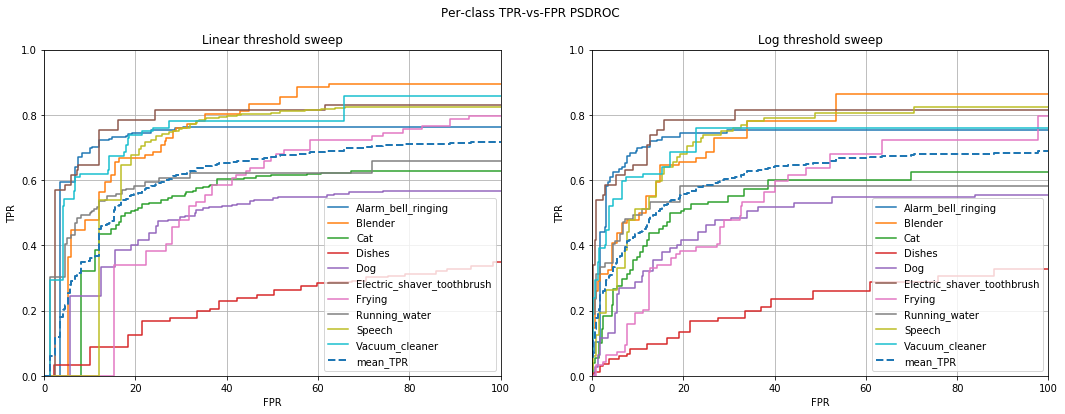

In [10]:
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
class_names = psds_eval.class_names
plt.suptitle("Per-class TPR-vs-FPR PSDROC")

tpr_vs_fpr_lin, _, _ = psds_eval.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr_lin, class_names, axes=axis[0], title="Linear threshold sweep", xlabel="FPR", xlim=100)

tpr_vs_fpr_log, _, _  = psds_eval_log.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr_log, class_names, axes=axis[1], title="Log threshold sweep", xlabel="FPR", xlim=100)

Even though the final PSD-Score has changed only slightly from 0.60744 to 0.60519, the curves **have improved significantly** in the low FPR area making a more precise comparison feasible. Notice the differences between linear threshold sweep (left) and log-based sweep (right) when FPR < 40. Worth noticing that also the `mean_TPR` dashed curve is smoother in the figure on the right.  
Avoiding gaps in the PSD-ROC curves is crucial to have a fine evaluation; it is therefore encouraged to use a *sufficient* number of thresholds, where "sufficient" is defined by having smooth curves in the area you are most interested in. If you are constrained by a maximum number of thresholds, distributing them strategically (like it was done in this example) can improve the evaluation.

---
## A flexible and robust evaluation framework

PSDS is flexible and robust because it can be adapted to different *use cases* and it can cope with ground truth imperfections. This section is going to provide an explanation of the logic behind the definition of event detection.

In [11]:
# instantiate the PSDSEval with the selected triplet of thresholds and the ground truth/metadata tabels
psds_eval = PSDSEval(dtc_threshold=0.5, gtc_threshold=0.5,
                     cttc_threshold=0.3, duration_unit="hour",
                     ground_truth=groundtruth, metadata=metadata)

**Definition of event detection via DTC, GTC and CTTC**

PSDS evaluation makes use of three parameters to define true positives (TPs), false positives (FPs) and cross-triggers (CTs):
- Detection Tolerance Criterion (DTC)
- Ground Truth intersection Criterion (GTC)
- Cross-Trigger Tolerance Criterion (CTTC)

The flowchart in the figure below shows an high-level summary of how DTC, GTC and CTTC criteria are employed by PSDS:
![alt text](./assets/psds_logic.jpg)
1. Given a set of detections and ground truths, the algorithm firstly applies the Detection Tolerance Criterion and identifies a subset of *valid detections* in those that have enough intersection (`dtc_threshold`) with ground truths of the same class. All the other detections become **FPs**
2. The GTC is now applied to each ground truth that intersects a *valid detection* and those sufficiently (`gtc_threshold`) covered by the detections become **TPs** while the others are undetected ground truths or missed detections.
3. The CTTC is now applied to the *not* valid detections that intersect ground truths of a different class. Those having enough intersection (`cttc_threshold`) with ground truth become **CTs**

A simple utility function called `sedogram` is used to visualise the ground truths (blue) and the system detections (red) for a given file. With the help of such visualisations one can more easily grasp the effect of this triplet of parameters on the evaluation.

In [12]:
def sedogram(det, gt, ax=None, title=""):
    """plot the sedogram for the given pair of detections and ground truths"""
    classes = set(gt.event_label.values)
    classes.update(set(det.event_label.values))
    classes = list(sorted(classes))
    n_classes = len(classes)
    
    def _draw_rectangles(df, y_offset, **kwargs):
        n_classes = len(classes)
        for c, grp in df.groupby("event_label"):
            idx = classes.index(c)
            for _, event in grp.iterrows():
                ts = event.onset
                te = event.offset
                dur = te - ts
                ax.add_patch(Rectangle(xy=(ts, n_classes-idx-1+y_offset), width=dur, height=kwargs.get("height"),
                                           facecolor=kwargs.get("facecolor"), alpha=kwargs.get("alpha")))
                
    if ax is None:
        fig, ax = plt.subplots(1, sharex=True, figsize=(14, 4))
    max_x = np.maximum(det.offset.max(), gt.offset.max())
    
    _draw_rectangles(gt, y_offset=0.1, facecolor="b", height=0.8, alpha=1.0)
    _draw_rectangles(det, y_offset=0.35, facecolor="r", height=0.3, alpha=0.7)
    ax.set_ylim([0, n_classes])
    if not np.isnan(max_x):
        ax.set_xlim([0, max_x])
        ax.set_xticks(np.arange(0, max_x, 0.5))
    ax.set_yticks(np.arange(n_classes, 0, -1) - 0.5)
    ax.set_yticklabels(classes)
    ax.set_xlabel("time (s)")
    ax.set_title(title)
    red_patch = Patch(color="red", alpha=0.7, label="System detection")
    blue_patch = Patch(color="blue", label="Ground truth")
    ax.legend(handles=[red_patch, blue_patch])

Sedograms of three pre-selected files are now plotted to help visualise how the PSDS intersection logic works. To this end, a single set of system detections is loaded:

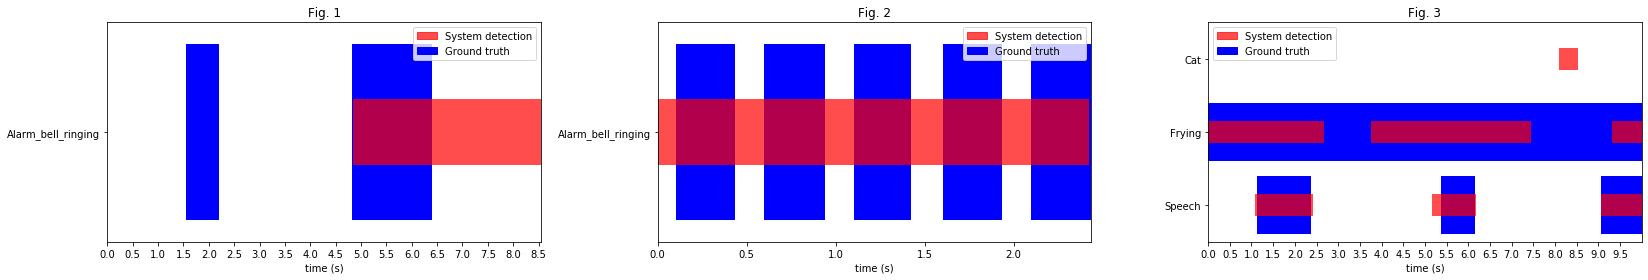

In [13]:
det_t = pd.read_csv("cache/validation_predictions/0.510.tsv", sep="\t")

preselected_files = ["YVWwk76SEAno_0.000_9.000.wav", "YMGVGO9mnvMQ_7.000_17.000.wav", "Y8AY0aXAQjwY_250.000_260.000.wav"]
fig, axis = plt.subplots(1, 3, figsize=(23, 4))
for i, filename in enumerate(preselected_files):
    sedogram(det_t[det_t.filename == filename], groundtruth[groundtruth.filename == filename], ax=axis[i], title=f"Fig. {i+1}")
plt.tight_layout()

The **Detection Tolerance Criterion (DTC) threshold** controls how precise a system detection has to be with respect to all the ground truths of the same class that it intersects. 
>The DTC is computed for *each system detection* `D_i`  as the **ratio** `L_ints / L_det`, where `L_det` is the detection length and `L_ints` is the total overlap between `D_i` and any ground truths of the same class.

The Fig. 1 sedogram shows that for the given file there are two *Alarm_bell_ringing* ground truths and one system detection for the same class. In this case `L_det = 3.7s` while `L_ints = 1.6s`, therefore the detection DTC is *0.424*. If the evaluation is configured with a DTC threshold of 0.5, such system detection will be counted as a *false positive*.

Depending on the use case, the `dtc_threshold` parameter can be lowered or increased in order to perform an evaluation that accepts imperfect detections or only very precise ones, respectively.

The example in Fig. 2 is interesting because the detection intersects five distinct ground truths. Since, the total overlap is `L_ints = 0.33 + 0.346 + 0.32 + 0.331 + 0.327 = 1.654s` and the detection length is `L_det = 2.422s`, given the same evaluation setup above (i.e., `dtc_threshold = 0.5`), the system detection is *valid* (`DTC = 1.654 / 2.422 = 0.68 > 0.5`). In order to count the number of true positives, the Ground Truth intersection Criterion (GTC) for each ground truth is going to be evaluated in the next paragraph.

The **Ground Truth intersection Criterion (GTC) threshold** defines the amount of minimum overlap necessary to count a ground truth correctly detected.
> The GTC is computed *for each ground truth* `G_i` *intersecting a valid detection* as the **ratio** `L_ints / L_gt`, where `L_gt` is the ground truth length and `L_ints` is the total overlap between `G_i` and any valid detection of the same class

Looking the sedogram in Fig. 2, each of the first 4 ground truth has a GTC equals to 1 therefore 4 *true positives* are counted. The fifth ground truth instead has GTC ratio approx. 0.96 and, assuming a `gtc_threshold = 0.5`, it is also counted as *true positive* for a total of 5 TPs for the class "Alarm_bell_ringing".

Similarly, a use case where the ground truth has to be completely covered by a detection can be represented in PSDSEval with a very high GTC threshold.

The **Cross-Trigger Tolerance Criterion (CTTC) threshold** is like the DTC, but it's applied to the system detections that intersect ground truths of other classes of interest for detection, as distinct from false alarms which don’t intersect with any other label.
> The CTTC is computed *for each non-valid detection* `D_i` that intersects a ground truth of different class as the **ratio** `L_ints / L_det`.

The sedogram in Fig. 3 shows that:
- the GTC is also evaluated across multiple detections: the Frying ground truth has three distinct detections but its GTC ratio will have the numerator `L_ints` accounting for the total overlap with *valid* detections. It's easy to see that all 3 Frying detections are valid since their DTC ratio is 1.
- the "Cat" detection is clearly a false positive, but `PSDSEval` also counts it as 1 cross-trigger of "Cat onto Frying" **if** the CTTC is satisfied. In this case, `L_ints = L_det = 0.5s` hence, assuming `cttc_threshold = 0.3`, the detection will be counted as cross-trigger.

**Optional**: You can keep exploring the system detections by running the following cell in which a random file is selected everytime it is executed and its sedogram is extracted.

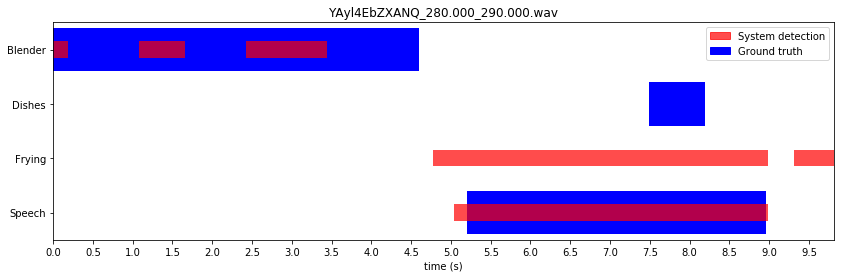

In [14]:
rand_filename = np.random.choice(det_t.filename)
sedogram(det_t[det_t.filename == rand_filename], groundtruth[groundtruth.filename == rand_filename], title=rand_filename)

---

## That's all
Thank you for your interest in PSDS evaluation and for reading this notebook thus far! We encourage you to adopt PSDS in your SED research and to contribute on [GitHub](https://github.com/audioanalytic/psds_eval). For any bug or feature request please open an issue [here](https://github.com/audioanalytic/psds_eval/issues).

---

The authors of the paper and the team responsible for the GitHub repo are all part of the team at Audio Analytic, based in Cambridge, UK

<a href="https://www.audioanalytic.com/" target="_blank"> <img src="https://www.audioanalytic.com/app/themes/audioanalytic/img/aa.svg" width=250> </a>

---

# References

[1] Ç. Bilen, G. Ferroni, F. Tuveri, J. Azcarreta and S. Krstulović, "A Framework for the Robust Evaluation of Sound Event Detection," ICASSP 2020 - 2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Barcelona, Spain, 2020, pp. 61-65.  
doi: 10.1109/ICASSP40776.2020.9052995  
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9052995&isnumber=9052899

